# Pendulum with Structured LNN and Control
- We know the data is angle and use it as advantage

## TODO:

- Plot Mass Matrix
- Plot Potential
- Understand the control

In [1]:
import numpy as np
import torch

import sys
import time
sys.path.append("../../")

## Train Model

In [2]:
# hparams
num_sample = 10000
batch_size = 128
portion = 0.5

learning_rate = 3e-4
min_delta = 0
patience = 30

time_horizon = 5
solver = 'rk4'

model_name = 'latent_dyn.pt'
# Check Model params in Model section

### Set Seed Here

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

### Load the data set
- init_condition: list of tuple

 [(x0, p0, t0, t1, steps)]

In [4]:
from gym_env import PendulumCustomEnv
from data import Gym_DataModule_rng

In [5]:
env = PendulumCustomEnv(full_phase=True)
low = np.array([-2])
high = -low

# env, time step, traj, control
dataModule = Gym_DataModule_rng(env,
                                num_sample,
                                low=low,
                                high=high,
                                no_act_portion=portion,
                                time_horizon=time_horizon,
                                batch_size=batch_size,
                                data_dir='../../data/dataset',
                                use_img=True)

dataModule.setup()

In [6]:
print(dataModule.dataset.tensors[0].shape)  # (bs, time, [cos q, sin, q, dq])
print(dataModule.dataset.tensors[1].shape)  # (bs, time, [control])
print(dataModule.dataset.tensors[2].shape)  # (bs, time, [time])
print(dataModule.dataset.tensors[3].shape)  # (bs, time, [th, dth, ddth])
print(dataModule.dataset.tensors[4].shape)  # (bs, time, images)

torch.Size([10000, 5, 3])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 1])
torch.Size([10000, 5, 3])
torch.Size([10000, 5, 28, 28, 2])


### Define Model

In [7]:
from torchdyn.models import NeuralODE

from module.LNNODE_latent import LNNODE_latent
from nn import MLP, PSD, MatrixNet

In [8]:
massMatrixNet = PSD([1, 64, 64, 1], activation='relu')
potentialNet = MLP([1, 64, 64, 1], activation='relu')
controlNet = MatrixNet([1, 64, 64, 1], control_dim=1, activation='relu')
# controlNet = MatrixNet([1, 1], control_dim=1, activation='relu')

lagFunc = LNNODE_latent(num_angle=0, 
                        massMatrixNet=massMatrixNet,
                        potentialNet=potentialNet,
                        controlNet=controlNet
                       )

lagODE = NeuralODE(lagFunc, sensitivity='adjoint', solver=solver).to(device)

In [9]:
torch.save(lagODE, 'models/before_{}'.format(model_name))

### Define Pytorch lightning trainer

In [10]:
import torch.nn.functional as F

import pytorch_lightning as pl

from pytorch_lightning.callbacks import EarlyStopping

In [11]:
class Learner(pl.LightningModule):
    def __init__(self, model: torch.nn.Module):
        super().__init__()
        self.model = model
        self.loss_func = F.mse_loss

    def forward(self, x):
        return self.model.defunc(0, x)

    def training_step(self, batch, batch_idx):
        stat = self.step(batch, batch_idx)
        self.logger.experiment.add_scalars("loss", {"train": stat['loss']}, self.current_epoch)
        return stat
    
    def validation_step(self, batch, batch_idx):
        stat = self.step(batch, batch_idx)
        self.log('val_loss', stat['loss'])
        self.logger.experiment.add_scalars("loss", {"val": stat['loss']}, self.current_epoch)
        return stat

    def step(self, batch, batch_idx):
        _, u, t, info, imgs = batch
        t_span = t[0, :, 0]
        bs = imgs.shape[0]
        time_horizon = t.shape[1]

        # Get image distance
        imgs_flatten = imgs.reshape(bs * time_horizon, -1)
        imgs_time_flatten = imgs.reshape(bs, time_horizon, -1)
        
        imgs_distM = torch.cdist(imgs_flatten, imgs_flatten, p=2)
        imgs_time_distM = torch.cdist(imgs_time_flatten, imgs_time_flatten, p=2)

        z = self.model.defunc.m.encoder(imgs)
        z0_u = torch.cat([z[:, 0, :], u[:, 0, :]], dim=1)
        z_est = self.model.trajectory(z0_u, t_span)[:, :, :-1].transpose(0, 1)
        z_err = self.loss_func(z, z_est)

        z_flatten = z_est.reshape(bs * time_horizon, -1)
        z_time_flatten = z.reshape(bs, time_horizon, -1)
        
        z_distM = torch.cdist(z_flatten, z_flatten, p=2)
        z_time_distM = torch.cdist(z_time_flatten, z_time_flatten, p=2)

        imgs_hat = self.model.defunc.m.decoder(z_est)

        recon_loss = self.loss_func(imgs, imgs_hat)
        dimg_loss = self.loss_func(imgs[:, 1:, :, :, 0] - imgs[:, :-1, :, :, 0], imgs_hat[:, 1:, :, :, 1])
        
        dist_loss = self.loss_func(torch.nn.functional.normalize(imgs_distM),
                                   torch.nn.functional.normalize(z_distM))
        
        dist_time_loss = self.loss_func(imgs_time_distM,
                                        z_time_distM
                                       )
        
        loss = 0
        loss += recon_loss
        loss += dist_loss
        loss += z_err
        loss += dist_time_loss
        # loss += dimg_loss

        return {'loss': loss, 'recon_loss': recon_loss, 'dist_loss': dist_loss, 'z_err': z_err}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=learning_rate)

    def training_epoch_end(self, outputs):
        print("\n recon: {:3e}, dist {:3e}, zerr {:3e} \n".format(outputs[-1]['recon_loss'],
                                                                  outputs[-1]['dist_loss'],
                                                                  outputs[-1]['z_err'])
             )

In [12]:
learn = Learner(lagODE)

early_stopping = EarlyStopping('val_loss', verbose=True, min_delta=min_delta, patience=patience)
trainer = pl.Trainer(callbacks=[early_stopping], min_epochs=500, max_epochs=5000)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores


### Train

In [13]:
start_time = time.time()

In [14]:
trainer.fit(learn, dataModule)


  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 2.2 M 
------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.850     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:348: UserWarning: Your val_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:102: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to impro

Training: 0it [00:00, ?it/s]


 recon: 3.792723e-03, dist 9.317123e-04, zerr 1.359755e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 2.993
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:610: LightningDeprecationWarning: Relying on `self.log('val_loss', ...)` to set the ModelCheckpoint monitor is deprecated in v1.2 and will be removed in v1.4. Please, create your own `mc = ModelCheckpoint(monitor='your_monitor')` and use it as `Trainer(callbacks=[mc])`.
  warning_cache.deprecation(



 recon: 4.029295e-03, dist 9.485843e-04, zerr 1.756630e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.098 >= min_delta = 0. New best score: 2.895



 recon: 3.778502e-03, dist 8.949036e-04, zerr 1.376077e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0. New best score: 2.861



 recon: 3.918992e-03, dist 8.799167e-04, zerr 1.438242e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0. New best score: 2.843



 recon: 3.783133e-03, dist 9.386860e-04, zerr 1.164956e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.013 >= min_delta = 0. New best score: 2.830



 recon: 3.877757e-03, dist 9.253892e-04, zerr 1.421070e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0. New best score: 2.810



 recon: 3.909424e-03, dist 9.117182e-04, zerr 1.388931e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.826181e-03, dist 8.845413e-04, zerr 1.387309e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.012 >= min_delta = 0. New best score: 2.798



 recon: 3.854803e-03, dist 9.213521e-04, zerr 1.429696e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.916688e-03, dist 9.296756e-04, zerr 1.439068e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.797



 recon: 3.941035e-03, dist 8.813965e-04, zerr 1.442813e+00 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0. New best score: 2.783



 recon: 3.848760e-03, dist 9.230388e-04, zerr 1.341524e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.892282e-03, dist 9.115736e-04, zerr 1.505538e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.940506e-03, dist 8.938889e-04, zerr 1.398003e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.951762e-03, dist 9.089405e-04, zerr 1.646917e+00 



Validating: 0it [00:00, ?it/s]


 recon: 4.052541e-03, dist 9.102954e-04, zerr 1.429213e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.670535e-03, dist 1.064417e-03, zerr 1.132585e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.725057e-03, dist 1.039633e-03, zerr 1.233991e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.897941e-03, dist 9.498592e-04, zerr 1.228912e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.695758e-03, dist 8.563150e-04, zerr 1.305387e+00 



Validating: 0it [00:00, ?it/s]


 recon: 4.180131e-03, dist 9.039970e-04, zerr 1.404961e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.909518e-03, dist 8.997526e-04, zerr 1.411525e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.748622e-03, dist 9.726247e-04, zerr 1.239246e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.817805e-03, dist 9.466220e-04, zerr 1.194637e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.898975e-03, dist 8.827235e-04, zerr 1.256185e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.875713e-03, dist 8.706743e-04, zerr 1.294629e+00 



Validating: 0it [00:00, ?it/s]


 recon: 4.052611e-03, dist 9.299234e-04, zerr 1.442702e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.687833e-03, dist 9.598538e-04, zerr 1.316665e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.864887e-03, dist 9.574423e-04, zerr 1.261774e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.583791e-03, dist 1.148526e-03, zerr 9.903532e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.781872e-03, dist 8.852734e-04, zerr 1.193548e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.687920e-03, dist 1.012528e-03, zerr 1.370107e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.893260e-03, dist 9.690543e-04, zerr 1.162656e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.978591e-03, dist 1.085183e-03, zerr 1.351922e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.811861e-03, dist 9.396104e-04, zerr 1.265064e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.653395e-03, dist 9.643174e-04, zerr 1.135466e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.799806e-03, dist 9.670102e-04, zerr 1.088303e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.791241e-03, dist 1.002291e-03, zerr 1.158707e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.761726e-03, dist 9.738972e-04, zerr 1.206905e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.798088e-03, dist 9.702093e-04, zerr 1.215821e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.835329e-03, dist 9.426046e-04, zerr 1.256541e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 30 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.709689e-03, dist 9.760749e-04, zerr 1.148282e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 31 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.616169e-03, dist 9.772893e-04, zerr 1.181315e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 32 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.627679e-03, dist 9.101509e-04, zerr 1.035123e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 33 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 4.036676e-03, dist 8.781246e-04, zerr 1.355085e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 34 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.646918e-03, dist 9.316424e-04, zerr 1.155418e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 35 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.583387e-03, dist 1.039324e-03, zerr 1.032332e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 36 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.711573e-03, dist 1.064655e-03, zerr 1.137545e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 37 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.728458e-03, dist 1.087066e-03, zerr 1.029219e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 38 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.885250e-03, dist 9.196955e-04, zerr 1.234211e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 39 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.799542e-03, dist 8.962982e-04, zerr 1.246221e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 40 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.697588e-03, dist 1.015213e-03, zerr 1.128711e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 41 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.508181e-03, dist 9.768477e-04, zerr 9.315888e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 42 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.802108e-03, dist 8.813044e-04, zerr 1.184710e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 43 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.866690e-03, dist 1.069591e-03, zerr 1.179738e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 44 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.702674e-03, dist 9.531336e-04, zerr 1.158755e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 45 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.566614e-03, dist 9.489091e-04, zerr 1.002075e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 46 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.791557e-03, dist 8.639075e-04, zerr 1.249816e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 47 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.892709e-03, dist 9.750917e-04, zerr 1.181851e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 48 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.755196e-03, dist 9.631368e-04, zerr 1.110029e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 49 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.833673e-03, dist 8.926925e-04, zerr 1.136279e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 50 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.726424e-03, dist 1.005371e-03, zerr 1.154581e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 51 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.980031e-03, dist 9.529596e-04, zerr 1.338608e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 52 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.587541e-03, dist 9.285745e-04, zerr 1.132507e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 53 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.707893e-03, dist 9.050897e-04, zerr 1.153305e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 54 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.899026e-03, dist 9.757170e-04, zerr 1.221581e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 55 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.816122e-03, dist 9.449305e-04, zerr 1.159297e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 56 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.547145e-03, dist 8.626292e-04, zerr 1.029693e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 57 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.833955e-03, dist 1.084327e-03, zerr 1.209338e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 58 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.592186e-03, dist 9.166134e-04, zerr 1.041314e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 59 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.858554e-03, dist 9.015491e-04, zerr 1.298376e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 60 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.804490e-03, dist 9.026091e-04, zerr 1.164985e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 61 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.828723e-03, dist 1.025864e-03, zerr 1.235292e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 62 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.599829e-03, dist 8.807045e-04, zerr 1.150169e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 63 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.702948e-03, dist 9.609528e-04, zerr 1.137286e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 64 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.686930e-03, dist 9.738684e-04, zerr 1.279711e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 65 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.844084e-03, dist 9.538046e-04, zerr 1.130883e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 66 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.756525e-03, dist 1.172203e-03, zerr 1.103096e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 67 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.923296e-03, dist 1.075673e-03, zerr 1.413888e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 68 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.613322e-03, dist 9.676539e-04, zerr 1.118029e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 69 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.779148e-03, dist 9.561427e-04, zerr 1.142081e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 70 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.576495e-03, dist 9.641239e-04, zerr 1.089022e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 71 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.497052e-03, dist 1.001504e-03, zerr 1.105510e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 72 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.517993e-03, dist 1.022574e-03, zerr 1.023102e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 73 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.552505e-03, dist 8.815819e-04, zerr 9.997473e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 74 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.565191e-03, dist 9.039337e-04, zerr 1.097244e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 75 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.530721e-03, dist 9.753147e-04, zerr 1.017026e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 76 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.696646e-03, dist 9.858748e-04, zerr 1.057528e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 77 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.859634e-03, dist 9.825605e-04, zerr 1.315436e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 78 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.702212e-03, dist 9.753359e-04, zerr 1.086898e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 79 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.421089e-03, dist 9.591794e-04, zerr 9.320490e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 80 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.683022e-03, dist 1.014379e-03, zerr 1.095762e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 81 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.699008e-03, dist 1.190803e-03, zerr 1.140727e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 82 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.656826e-03, dist 1.008499e-03, zerr 1.147982e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 83 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.502015e-03, dist 1.202808e-03, zerr 9.469039e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 84 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.677226e-03, dist 1.340784e-03, zerr 1.096937e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 85 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.462994e-03, dist 9.731425e-04, zerr 9.195439e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 86 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.587023e-03, dist 1.151083e-03, zerr 1.045708e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 87 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.574107e-03, dist 1.084425e-03, zerr 1.125507e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 88 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.492106e-03, dist 1.053584e-03, zerr 9.542223e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 89 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.719508e-03, dist 1.085541e-03, zerr 1.173751e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 90 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.587430e-03, dist 1.221791e-03, zerr 9.751217e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 91 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.824536e-03, dist 1.251817e-03, zerr 1.083470e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 92 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.686219e-03, dist 1.322210e-03, zerr 8.476401e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 93 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.581054e-03, dist 1.078025e-03, zerr 1.128554e+00 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 94 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.613335e-03, dist 1.174144e-03, zerr 9.460207e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 95 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.529834e-03, dist 1.211955e-03, zerr 8.846070e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 96 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.329917e-03, dist 1.233304e-03, zerr 9.891891e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 97 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.245451e-03, dist 1.245506e-03, zerr 6.882353e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 98 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.464115e-03, dist 1.213310e-03, zerr 8.875986e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 99 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.395200e-03, dist 1.221777e-03, zerr 8.691249e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 100 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.614493e-03, dist 1.161229e-03, zerr 8.115398e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 101 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.521008e-03, dist 1.153214e-03, zerr 9.080138e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 102 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.751736e-03, dist 1.301970e-03, zerr 9.547498e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 103 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.392209e-03, dist 1.161720e-03, zerr 8.488970e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 104 records. Best score: 2.783. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.502203e-03, dist 1.226673e-03, zerr 8.994234e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0. New best score: 2.782



 recon: 3.454327e-03, dist 1.101644e-03, zerr 9.778457e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.653186e-03, dist 1.179663e-03, zerr 8.954683e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.018 >= min_delta = 0. New best score: 2.764



 recon: 3.579534e-03, dist 1.277941e-03, zerr 9.724476e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.561697e-03, dist 1.209335e-03, zerr 8.383293e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.685766e-03, dist 1.235777e-03, zerr 8.575905e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0. New best score: 2.754



 recon: 3.628017e-03, dist 1.252043e-03, zerr 1.014723e+00 



Validating: 0it [00:00, ?it/s]


 recon: 3.409669e-03, dist 1.225133e-03, zerr 8.128363e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.009 >= min_delta = 0. New best score: 2.744



 recon: 3.211661e-03, dist 1.093847e-03, zerr 7.074320e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.433256e-03, dist 1.070716e-03, zerr 7.942222e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.241888e-03, dist 1.238473e-03, zerr 6.586404e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.192259e-03, dist 1.269789e-03, zerr 7.669662e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0. New best score: 2.737



 recon: 3.438383e-03, dist 1.114585e-03, zerr 7.443900e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.513581e-03, dist 1.243570e-03, zerr 7.807111e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.401734e-03, dist 1.182760e-03, zerr 6.925702e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.375865e-03, dist 1.179732e-03, zerr 9.038658e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.020 >= min_delta = 0. New best score: 2.717



 recon: 3.487743e-03, dist 1.259163e-03, zerr 8.026842e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.483960e-03, dist 1.168797e-03, zerr 7.250059e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.285129e-03, dist 1.141468e-03, zerr 8.623766e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.102152e-03, dist 1.145237e-03, zerr 6.986719e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0. New best score: 2.712



 recon: 3.237179e-03, dist 1.066545e-03, zerr 6.796655e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.340883e-03, dist 1.051374e-03, zerr 6.705225e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.331943e-03, dist 1.084515e-03, zerr 6.690683e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.281963e-03, dist 1.257864e-03, zerr 7.479103e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.373643e-03, dist 1.223949e-03, zerr 8.353081e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.297132e-03, dist 1.419356e-03, zerr 8.808008e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.343500e-03, dist 1.184740e-03, zerr 8.445201e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.154600e-03, dist 1.050983e-03, zerr 6.675202e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.075937e-03, dist 1.082723e-03, zerr 5.915173e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.176813e-03, dist 1.245099e-03, zerr 7.008420e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.258527e-03, dist 1.071959e-03, zerr 6.783015e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.105739e-03, dist 1.145757e-03, zerr 7.038592e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.185581e-03, dist 1.050201e-03, zerr 5.935633e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.214445e-03, dist 1.077586e-03, zerr 6.389349e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.165073e-03, dist 1.021621e-03, zerr 6.669950e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.124067e-03, dist 1.216955e-03, zerr 6.921766e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.079647e-03, dist 1.306675e-03, zerr 7.237936e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.098967e-03, dist 1.030779e-03, zerr 5.712894e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.099084e-03, dist 1.087828e-03, zerr 6.124573e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.286477e-03, dist 1.071882e-03, zerr 6.857180e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.254548e-03, dist 1.047359e-03, zerr 6.580322e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.286939e-03, dist 1.077200e-03, zerr 8.657085e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.191106e-03, dist 1.079537e-03, zerr 6.333885e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.174928e-03, dist 1.053516e-03, zerr 5.506378e-01 



Validating: 0it [00:00, ?it/s]


 recon: 2.956950e-03, dist 1.025753e-03, zerr 5.918391e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.298496e-03, dist 1.070490e-03, zerr 7.315674e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.237334e-03, dist 1.091440e-03, zerr 6.663969e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.454990e-03, dist 1.125002e-03, zerr 7.943756e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.106392e-03, dist 1.030734e-03, zerr 6.834431e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.061068e-03, dist 1.054167e-03, zerr 5.620592e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 30 records. Best score: 2.712. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.086688e-03, dist 1.082918e-03, zerr 6.607529e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0. New best score: 2.711



 recon: 3.263762e-03, dist 1.007578e-03, zerr 6.583318e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.153322e-03, dist 1.113810e-03, zerr 6.381145e-01 



Validating: 0it [00:00, ?it/s]

Metric val_loss improved by 0.007 >= min_delta = 0. New best score: 2.703



 recon: 2.958303e-03, dist 1.063221e-03, zerr 6.408392e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.185207e-03, dist 1.118313e-03, zerr 6.708006e-01 



Validating: 0it [00:00, ?it/s]


 recon: 2.933607e-03, dist 1.059139e-03, zerr 5.504902e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.238196e-03, dist 1.011377e-03, zerr 6.132498e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.130754e-03, dist 1.098628e-03, zerr 7.095605e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.060285e-03, dist 1.036608e-03, zerr 6.434288e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.133007e-03, dist 9.803763e-04, zerr 6.315015e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.054323e-03, dist 1.130820e-03, zerr 5.867819e-01 



Validating: 0it [00:00, ?it/s]


 recon: 2.979840e-03, dist 1.022396e-03, zerr 5.289359e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.080463e-03, dist 1.138829e-03, zerr 5.823045e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.121518e-03, dist 1.125688e-03, zerr 6.367446e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.117037e-03, dist 1.044841e-03, zerr 6.162508e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.066938e-03, dist 1.032178e-03, zerr 6.098403e-01 



Validating: 0it [00:00, ?it/s]


 recon: 2.978810e-03, dist 1.047015e-03, zerr 5.830706e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.163092e-03, dist 1.062803e-03, zerr 7.594332e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.017881e-03, dist 1.130381e-03, zerr 6.668088e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.005328e-03, dist 1.078032e-03, zerr 6.261076e-01 



Validating: 0it [00:00, ?it/s]


 recon: 2.964378e-03, dist 1.045393e-03, zerr 5.428972e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.059324e-03, dist 9.380456e-04, zerr 6.440803e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.124745e-03, dist 1.038809e-03, zerr 6.645476e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.040962e-03, dist 1.057958e-03, zerr 6.511559e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.209993e-03, dist 1.049279e-03, zerr 7.442091e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.005534e-03, dist 1.029351e-03, zerr 5.908870e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.105363e-03, dist 1.120277e-03, zerr 6.182913e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.052540e-03, dist 1.041857e-03, zerr 4.942890e-01 



Validating: 0it [00:00, ?it/s]


 recon: 2.922364e-03, dist 1.174224e-03, zerr 5.197824e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.360712e-03, dist 1.110873e-03, zerr 7.878178e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.012829e-03, dist 9.971010e-04, zerr 6.220286e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.102330e-03, dist 1.190832e-03, zerr 6.276926e-01 



Validating: 0it [00:00, ?it/s]


 recon: 3.068690e-03, dist 1.089269e-03, zerr 6.197740e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 30 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.950228e-03, dist 9.790546e-04, zerr 6.337682e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 31 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.134754e-03, dist 1.009080e-03, zerr 5.525464e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 32 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.063639e-03, dist 9.963341e-04, zerr 6.165041e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 33 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.077487e-03, dist 1.061090e-03, zerr 5.666425e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 34 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.995131e-03, dist 1.040191e-03, zerr 6.796780e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 35 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.156610e-03, dist 9.970008e-04, zerr 5.836693e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 36 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.186333e-03, dist 1.081870e-03, zerr 6.167192e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 37 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.174014e-03, dist 1.033406e-03, zerr 6.033688e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 38 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.828111e-03, dist 1.026918e-03, zerr 5.561370e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 39 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.091947e-03, dist 1.059425e-03, zerr 5.812679e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 40 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.884473e-03, dist 1.057059e-03, zerr 6.054437e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 41 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.869787e-03, dist 1.097391e-03, zerr 4.629480e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 42 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.028805e-03, dist 1.111087e-03, zerr 5.397504e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 43 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.155683e-03, dist 9.871621e-04, zerr 5.644010e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 44 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.964576e-03, dist 1.000727e-03, zerr 5.207399e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 45 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.958804e-03, dist 1.041898e-03, zerr 5.159803e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 46 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.992395e-03, dist 1.056268e-03, zerr 5.348380e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 47 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.024820e-03, dist 1.059957e-03, zerr 5.950767e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 48 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.089639e-03, dist 1.133210e-03, zerr 6.188200e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 49 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.041302e-03, dist 1.055897e-03, zerr 5.405859e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 50 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.945819e-03, dist 1.052813e-03, zerr 6.643913e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 51 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.055148e-03, dist 1.039920e-03, zerr 6.096748e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 52 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.033971e-03, dist 9.835371e-04, zerr 5.519987e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 53 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.010331e-03, dist 1.087220e-03, zerr 5.795309e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 54 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.078750e-03, dist 9.807495e-04, zerr 6.478066e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 55 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.069350e-03, dist 1.095560e-03, zerr 5.854572e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 56 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.035741e-03, dist 1.156666e-03, zerr 5.225964e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 57 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.110291e-03, dist 1.185532e-03, zerr 7.765722e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 58 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.096419e-03, dist 1.091279e-03, zerr 6.567932e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 59 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.935271e-03, dist 1.066675e-03, zerr 5.453154e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 60 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.976742e-03, dist 9.943309e-04, zerr 5.986323e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 61 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.887884e-03, dist 1.053905e-03, zerr 5.834869e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 62 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.102471e-03, dist 9.944874e-04, zerr 6.698884e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 63 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.974048e-03, dist 1.057324e-03, zerr 5.964095e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 64 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.028336e-03, dist 1.075919e-03, zerr 6.439888e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 65 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.900490e-03, dist 9.954390e-04, zerr 4.660729e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 66 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.048391e-03, dist 1.089649e-03, zerr 4.903927e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 67 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.920319e-03, dist 1.013694e-03, zerr 5.244897e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 68 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.953389e-03, dist 1.030041e-03, zerr 4.946412e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 69 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.055713e-03, dist 9.999006e-04, zerr 5.949887e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 70 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.008846e-03, dist 1.020807e-03, zerr 7.333232e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 71 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.009380e-03, dist 1.057213e-03, zerr 5.792992e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 72 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.884160e-03, dist 9.585438e-04, zerr 5.341769e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 73 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.974808e-03, dist 9.500912e-04, zerr 4.707014e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 74 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.310176e-03, dist 1.058240e-03, zerr 6.769615e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 75 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.096643e-03, dist 1.022596e-03, zerr 5.978405e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 76 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.972110e-03, dist 9.769037e-04, zerr 7.160031e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 77 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.247363e-03, dist 1.046165e-03, zerr 6.553969e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 78 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.851106e-03, dist 9.738201e-04, zerr 5.457437e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 79 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.782193e-03, dist 9.600132e-04, zerr 5.089010e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 80 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.850311e-03, dist 1.033282e-03, zerr 5.253847e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 81 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.911002e-03, dist 1.075934e-03, zerr 5.477166e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 82 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.009138e-03, dist 1.070213e-03, zerr 5.441496e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 83 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.036622e-03, dist 1.021116e-03, zerr 6.405937e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 84 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.811312e-03, dist 1.009950e-03, zerr 5.523434e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 85 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.121776e-03, dist 1.077484e-03, zerr 5.480062e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 86 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.817333e-03, dist 1.031150e-03, zerr 4.878899e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 87 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.001274e-03, dist 1.003294e-03, zerr 5.802580e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 88 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.981031e-03, dist 9.686960e-04, zerr 5.794892e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 89 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.759735e-03, dist 1.103303e-03, zerr 4.483806e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 90 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.930565e-03, dist 9.324180e-04, zerr 4.836207e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 91 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.863272e-03, dist 1.072187e-03, zerr 5.053138e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 92 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.972583e-03, dist 1.147153e-03, zerr 5.825018e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 93 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.872447e-03, dist 1.101722e-03, zerr 5.946291e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 94 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.043164e-03, dist 1.024948e-03, zerr 5.639348e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 95 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.991259e-03, dist 1.050221e-03, zerr 5.638262e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 96 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.952500e-03, dist 1.129728e-03, zerr 5.131147e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 97 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.912500e-03, dist 9.626203e-04, zerr 4.726898e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 98 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.077537e-03, dist 8.530431e-04, zerr 5.604409e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 99 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.922950e-03, dist 9.941172e-04, zerr 4.831817e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 100 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.004650e-03, dist 1.049987e-03, zerr 5.293809e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 101 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.008811e-03, dist 1.032246e-03, zerr 5.830789e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 102 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.950931e-03, dist 1.090866e-03, zerr 5.372579e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 103 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.049894e-03, dist 1.049605e-03, zerr 5.249989e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 104 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.827515e-03, dist 1.088831e-03, zerr 4.707046e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 105 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.859276e-03, dist 9.132696e-04, zerr 5.611382e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 106 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.854636e-03, dist 1.004374e-03, zerr 4.804862e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 107 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.027181e-03, dist 9.838457e-04, zerr 6.422624e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 108 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.918479e-03, dist 1.046776e-03, zerr 5.969537e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 109 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.090080e-03, dist 1.071453e-03, zerr 5.051462e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 110 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.898375e-03, dist 9.227095e-04, zerr 5.032664e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 111 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.000107e-03, dist 1.013164e-03, zerr 5.410922e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 112 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.797557e-03, dist 1.000464e-03, zerr 5.149291e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 113 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.114049e-03, dist 1.064268e-03, zerr 6.094617e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 114 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.834194e-03, dist 9.797607e-04, zerr 5.423543e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 115 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.998531e-03, dist 1.045358e-03, zerr 5.012892e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 116 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.863842e-03, dist 1.224555e-03, zerr 4.816046e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 117 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.866381e-03, dist 1.090253e-03, zerr 5.652083e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 118 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.932480e-03, dist 1.025234e-03, zerr 6.359939e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 119 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.993785e-03, dist 1.050465e-03, zerr 5.697496e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 120 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.957040e-03, dist 1.008304e-03, zerr 4.926749e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 121 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.756578e-03, dist 1.145172e-03, zerr 4.515329e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 122 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.991987e-03, dist 1.078531e-03, zerr 5.133325e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 123 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.084762e-03, dist 1.089425e-03, zerr 5.706462e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 124 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.764564e-03, dist 1.016243e-03, zerr 5.858476e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 125 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.138819e-03, dist 9.810266e-04, zerr 6.137710e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 126 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.002915e-03, dist 9.697676e-04, zerr 5.267457e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 127 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.866608e-03, dist 9.835500e-04, zerr 5.434567e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 128 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.829463e-03, dist 1.071751e-03, zerr 4.961739e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 129 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.027902e-03, dist 1.001900e-03, zerr 5.833542e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 130 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.835317e-03, dist 9.779496e-04, zerr 4.936911e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 131 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.835247e-03, dist 9.932959e-04, zerr 5.535092e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 132 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.922067e-03, dist 1.002072e-03, zerr 6.630382e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 133 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.829045e-03, dist 9.944614e-04, zerr 4.947620e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 134 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.901491e-03, dist 1.132204e-03, zerr 4.984429e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 135 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.138681e-03, dist 1.042450e-03, zerr 7.182931e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 136 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.949647e-03, dist 9.475435e-04, zerr 5.335310e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 137 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.872913e-03, dist 1.079013e-03, zerr 4.934618e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 138 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.967569e-03, dist 1.104639e-03, zerr 6.175801e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 139 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.654197e-03, dist 1.073741e-03, zerr 5.045422e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 140 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.865604e-03, dist 9.604050e-04, zerr 4.908350e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 141 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.996791e-03, dist 1.075320e-03, zerr 5.298066e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 142 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.827171e-03, dist 1.024980e-03, zerr 5.264958e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 143 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.901565e-03, dist 1.006340e-03, zerr 5.267291e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 144 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.837163e-03, dist 1.037283e-03, zerr 5.042899e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 145 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.999377e-03, dist 1.059929e-03, zerr 5.006416e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 146 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.944538e-03, dist 9.294765e-04, zerr 5.127904e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 147 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.817813e-03, dist 1.037147e-03, zerr 5.286509e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 148 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.120888e-03, dist 1.154012e-03, zerr 5.446446e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 149 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.918765e-03, dist 1.022641e-03, zerr 5.452358e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 150 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.831945e-03, dist 1.008115e-03, zerr 4.977599e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 151 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.955971e-03, dist 1.004425e-03, zerr 4.787787e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 152 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.971123e-03, dist 1.059227e-03, zerr 6.076882e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 153 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.007931e-03, dist 9.467510e-04, zerr 6.254318e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 154 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.067813e-03, dist 9.954131e-04, zerr 6.251137e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 155 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.963958e-03, dist 1.091575e-03, zerr 5.083468e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 156 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.877188e-03, dist 9.502084e-04, zerr 5.588826e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 157 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.764513e-03, dist 1.094298e-03, zerr 4.946450e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 158 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.191841e-03, dist 1.012513e-03, zerr 5.654238e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 159 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.799048e-03, dist 9.698936e-04, zerr 4.847866e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 160 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.829728e-03, dist 1.009724e-03, zerr 6.600639e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 161 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.950582e-03, dist 1.002204e-03, zerr 5.524274e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 162 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.947524e-03, dist 1.017326e-03, zerr 4.558285e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 163 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.008532e-03, dist 1.044750e-03, zerr 7.401299e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 164 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.026739e-03, dist 1.004927e-03, zerr 5.909664e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 165 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.865938e-03, dist 9.313311e-04, zerr 5.626715e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 166 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.771289e-03, dist 1.036490e-03, zerr 4.631253e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 167 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.943556e-03, dist 1.127067e-03, zerr 6.048173e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 168 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.663314e-03, dist 9.298928e-04, zerr 4.294526e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 169 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.869927e-03, dist 9.650491e-04, zerr 5.281755e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 170 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.877529e-03, dist 1.100886e-03, zerr 4.769333e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 171 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.053917e-03, dist 1.008265e-03, zerr 4.740429e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 172 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.991022e-03, dist 1.036601e-03, zerr 5.568698e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 173 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.806587e-03, dist 9.487626e-04, zerr 5.064600e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 174 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.883533e-03, dist 1.096278e-03, zerr 4.961918e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 175 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.962393e-03, dist 1.119359e-03, zerr 5.310518e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 176 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.053389e-03, dist 9.970459e-04, zerr 5.499398e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 177 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.048304e-03, dist 1.081835e-03, zerr 5.617957e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 178 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.858570e-03, dist 1.031848e-03, zerr 4.919396e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 179 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.837642e-03, dist 1.049222e-03, zerr 5.464118e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 180 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.956615e-03, dist 9.841466e-04, zerr 5.420787e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 181 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.917605e-03, dist 1.128129e-03, zerr 4.580095e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 182 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.953953e-03, dist 1.038252e-03, zerr 5.399938e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 183 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.890480e-03, dist 1.060199e-03, zerr 5.187352e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 184 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.838588e-03, dist 1.003764e-03, zerr 5.073386e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 185 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.863812e-03, dist 1.035293e-03, zerr 4.902457e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 186 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.926704e-03, dist 1.072127e-03, zerr 5.007754e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 187 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.058873e-03, dist 9.747385e-04, zerr 5.140545e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 188 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.962016e-03, dist 1.016618e-03, zerr 4.800085e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 189 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.806377e-03, dist 1.028314e-03, zerr 4.321579e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 190 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.881138e-03, dist 1.036641e-03, zerr 4.468421e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 191 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.735959e-03, dist 1.128120e-03, zerr 5.401853e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 192 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.799630e-03, dist 1.097489e-03, zerr 4.402080e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 193 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.869217e-03, dist 1.053595e-03, zerr 4.906939e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 194 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.675613e-03, dist 9.511732e-04, zerr 5.506876e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 195 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.766977e-03, dist 1.187409e-03, zerr 5.783638e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 196 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.833814e-03, dist 1.015327e-03, zerr 5.035581e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 197 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.843168e-03, dist 1.061167e-03, zerr 5.019040e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 198 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.973116e-03, dist 9.203208e-04, zerr 5.526273e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 199 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.026980e-03, dist 9.871713e-04, zerr 5.851157e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 200 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.836259e-03, dist 1.081137e-03, zerr 4.933552e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 201 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.902908e-03, dist 1.252545e-03, zerr 6.347290e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 202 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.918629e-03, dist 1.072337e-03, zerr 5.160583e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 203 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.107035e-03, dist 9.995613e-04, zerr 5.545350e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 204 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.873794e-03, dist 1.033537e-03, zerr 5.644596e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 205 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.658459e-03, dist 9.955658e-04, zerr 4.971753e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 206 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.755973e-03, dist 1.075949e-03, zerr 4.615469e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 207 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.951122e-03, dist 1.035997e-03, zerr 5.216461e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 208 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.803947e-03, dist 1.197428e-03, zerr 4.399773e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 209 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.865528e-03, dist 1.060682e-03, zerr 5.645316e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 210 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.841929e-03, dist 1.023947e-03, zerr 5.236642e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 211 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.866781e-03, dist 9.512963e-04, zerr 4.654351e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 212 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.978520e-03, dist 1.092281e-03, zerr 4.922527e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 213 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.956626e-03, dist 1.010245e-03, zerr 5.952537e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 214 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.986790e-03, dist 1.042197e-03, zerr 5.546409e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 215 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.906675e-03, dist 1.090802e-03, zerr 5.871096e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 216 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.857615e-03, dist 1.011439e-03, zerr 4.362027e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 217 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.947278e-03, dist 9.969063e-04, zerr 6.127290e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 218 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 3.132039e-03, dist 1.063112e-03, zerr 7.123945e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 219 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.870131e-03, dist 1.005258e-03, zerr 4.420928e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 220 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.930657e-03, dist 1.028369e-03, zerr 4.247359e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 221 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.781839e-03, dist 1.094389e-03, zerr 4.336671e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 222 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.856415e-03, dist 1.069214e-03, zerr 4.974056e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 223 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.838537e-03, dist 1.154048e-03, zerr 5.689213e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 224 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...



 recon: 2.922203e-03, dist 9.755754e-04, zerr 4.940677e-01 



Validating: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 225 records. Best score: 2.703. Signaling Trainer to stop.
Trainer was signaled to stop but required minimum epochs (500) or minimum steps (None) has not been met. Training will continue...
/Users/fei/miniconda3/envs/mbrlhnn/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


In [15]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 7438.718767166138 seconds ---


### Save Model
- Pytorch Lightning model check point is buggy
- Use Pytorch save and load method instead

In [16]:
torch.save(lagODE, 'models/{}'.format(model_name))

## Model Analysis

In [17]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator

### Load Model

In [18]:
test_model = torch.load('models/{}'.format(model_name))
test_model.eval()

test_model = test_model

### Generate trajectory with Gym Env

In [19]:
# define testing time stamp
dt = 0.05
full = 200
t_span = torch.linspace(dt, dt*full, full)

In [20]:
import cv2
def preproc_pend(img):
    gray = cv2.cvtColor(img[220: 780, 220: 780, :], cv2.COLOR_BGR2GRAY)  # Grey Scale
    img = cv2.resize(gray, [28, 28])  # Rescale image
    img[img == 255] = 0  # Black background (0 seems better for training)
    output = img / 255
    return output

In [21]:
# Generate Trajectory
env.seed(0)
np.random.seed(0)

env = PendulumCustomEnv()
obs = []
infos = []
images = []

# control = 2
# controls = np.random.randint(-2, 2 + 1, full+1)
split = 20
controls = np.random.randint(-2, 2 + 1, int(full / split))
controls = np.repeat(controls, split)
# controls = np.zeros_like(controls)

# obs0, _ = env.reset(np.array([3., 1.]))
obs0, _ = env.reset(np.array([np.pi / 2, 0.]))

prev_obs = obs0
prev_img = env.render('rgb_array')

for i in range(full):
    obs.append(prev_obs)
    images.append(preproc_pend(prev_img))
    
    next_obs, reward, done, info = env.step(controls[i])
    next_img = env.render('rgb_array')
    
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    
    prev_obs = next_obs
    prev_img = next_img

obs = torch.tensor(obs)
infos = torch.tensor(infos)
imgs = torch.tensor(images)
controls = torch.Tensor(controls).view(-1, 1)
env.close()

### Generate Prediction

In [22]:
P = imgs[1:, :, :]
dP = imgs[1:, :, :] - imgs[:-1, :, :]
P_dP = torch.stack([P, dP], dim=3)

In [23]:
dataModule.dataset.tensors[4].shape
P_dP.shape

torch.Size([199, 28, 28, 2])

In [24]:
z = test_model.defunc.m.encoder(P_dP.view(-1, *P_dP.shape).float())
z_raw = test_model.defunc.m.encoder(dataModule.dataset.tensors[4].float())

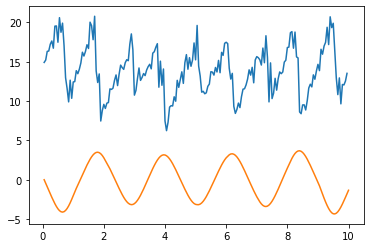

In [25]:
plt.plot(t_span[:full-1].detach().numpy(), z[0, :full-1, 1].detach().numpy())
plt.plot(t_span.detach().numpy(), infos[:, 1].detach().numpy())
# plt.plot(t_span[:full-1].detach().numpy() controls[:full-1])
# plt.ylim(-4, 4)

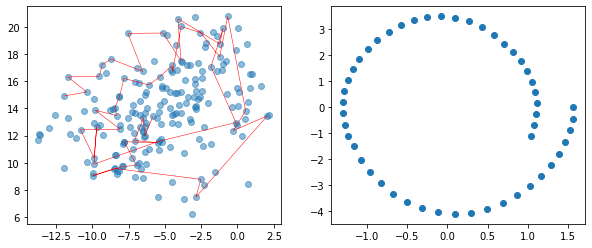

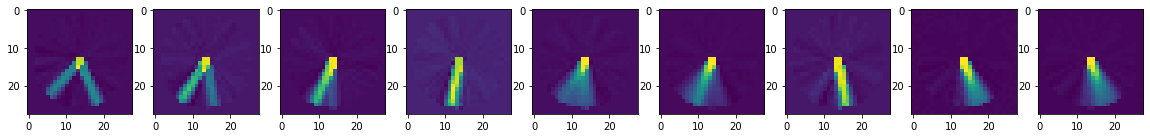

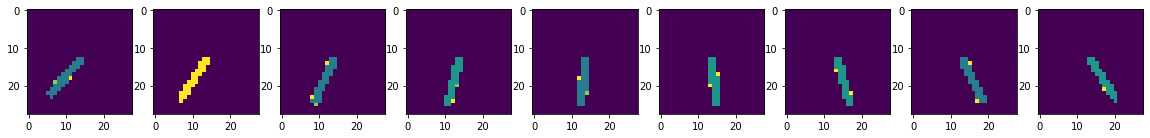

In [26]:
length = 50
start = 30

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(z[0, :, 0].detach().numpy(), z[0, :, 1].detach().numpy(), alpha=0.5)
ax1.plot(z[0, 0:length, 0].detach().numpy(), z[0, 0:length, 1].detach().numpy(), 'r-', linewidth=0.5)
# ax1.plot(est_z2[0:length, 0].detach().numpy(), est_z2[0:length, 1].detach().numpy(), 'g-', linewidth=0.5)
ax2.scatter(infos[:length, 0], infos[:length, 1])

fig1 = plt.figure(figsize=(20, 4))
fig2 = plt.figure(figsize=(20, 4))
ax1s = [fig1.add_subplot(191+i) for i in range(9)]
ax2s = [fig2.add_subplot(191+i) for i in range(9)]

test_img = test_model.defunc.m.decoder(z)
for i in range(9):
    ax1s[i].imshow(test_img[0, start + i, :, :, 0].detach().numpy())
    ax2s[i].imshow(P_dP[start + i, :, :, 0].detach().numpy())

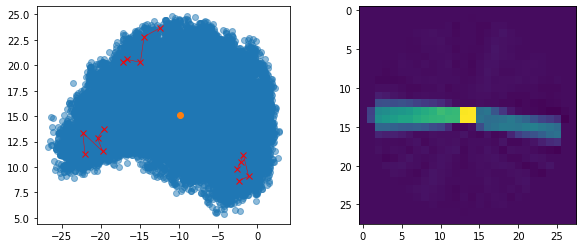

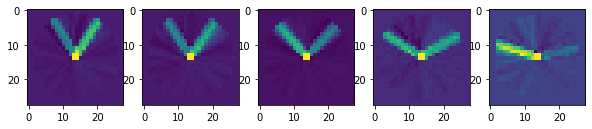

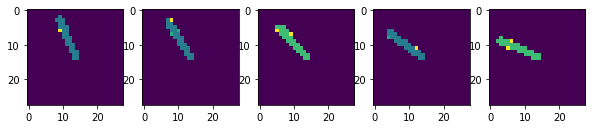

In [27]:
t = 4
bs = 5
# test_pt = torch.tensor([-0.039, 0.]).float()
test_pt = torch.mean(z_raw, dim=(0, 1))
test_img = test_model.defunc.m.decoder(test_pt.view(1, 1, -1))

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(z_raw[:, :, 0].detach().numpy(), z_raw[:, :, 1].detach().numpy(), alpha=0.5)
# idx = np.random.randint(0, 10000, (10, ))
idx = range(bs, bs+3)
for j in idx:
    ax1.plot(z_raw[j, :, 0].detach().numpy(), z_raw[j, :, 1].detach().numpy(), 'rx-', linewidth=0.5)
# ax1.plot(z_raw[bs, :, 0].detach().numpy(), z_raw[bs, :, 1].detach().numpy(), 'rx-', linewidth=0.5)

ax1.scatter(test_pt[0].detach().numpy(), test_pt[1].detach().numpy())
ax2.imshow(test_img[0, 0, :, :, 0].detach().numpy())

fig1 = plt.figure(figsize=(10, 4))
fig2 = plt.figure(figsize=(10, 4))
ax1s = [fig1.add_subplot(201+ time_horizon*10 +i) for i in range(time_horizon)]
ax2s = [fig2.add_subplot(201+ time_horizon*10 +i) for i in range(time_horizon)]

test_img = test_model.defunc.m.decoder(z_raw[[bs], :, :])
for i in range(time_horizon):
    ax1s[i].imshow(test_img[0, i, :, :, 0].detach().numpy())
    ax2s[i].imshow(dataModule.dataset.tensors[4][bs, i, :, :, 0].detach().numpy())

In [28]:
from utils import traj_pred

# Generate prediction

q_dq_u = torch.cat([z[0, :, :], controls[1:, :]], dim=1)
q_dq = z[0, :]
est_grad = test_model.defunc(0, q_dq_u.float())
est_z = traj_pred(0.05, test_model, q_dq[0, :].detach().numpy(), controls)

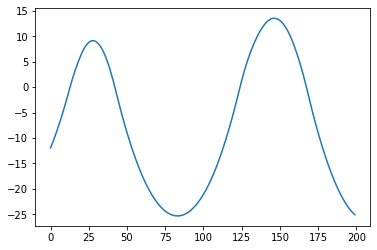

In [29]:
plt.plot(est_z.y[0, :])
# plt.plot(infos[:, 0].detach().numpy())

In [30]:
est_z2 = torch.tensor(est_z.y.T)

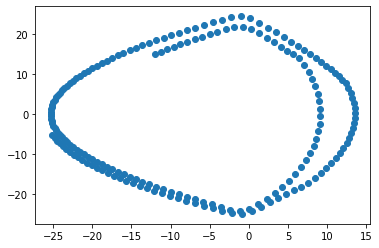

In [31]:
plt.scatter(est_z2[:, 0], est_z2[:, 1])

In [32]:
recon_img = test_model.defunc.m.decoder(est_z2.view(1, 200, -1).float())

In [33]:
recon_img.shape

torch.Size([1, 200, 28, 28, 2])

<ipython-input-34-c136c142605f>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(7, 3))


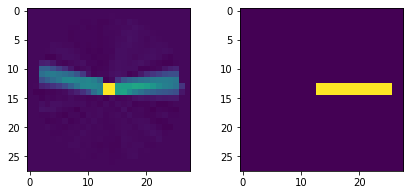

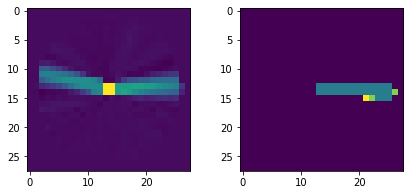

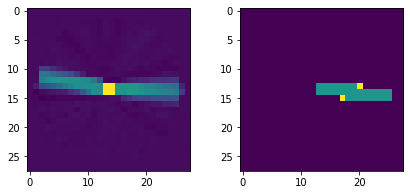

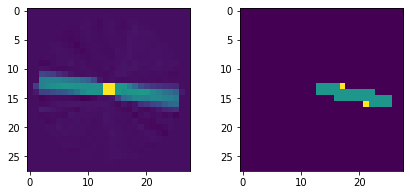

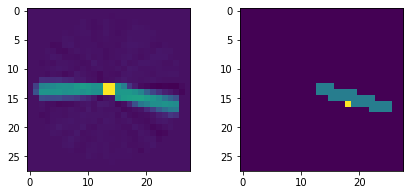

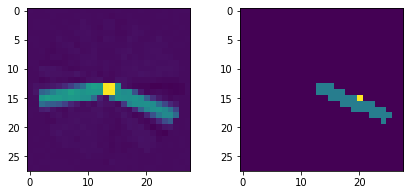

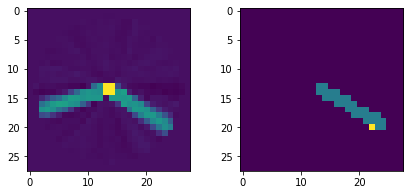

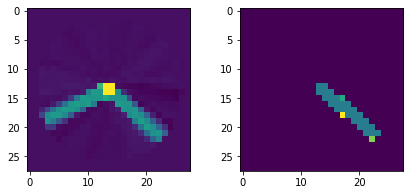

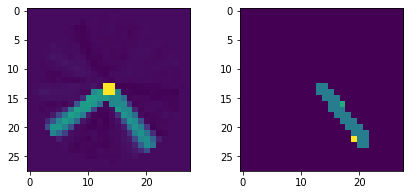

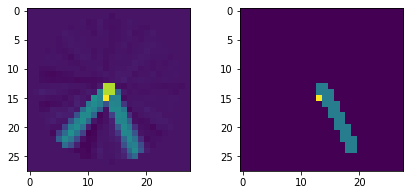

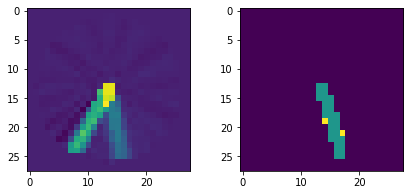

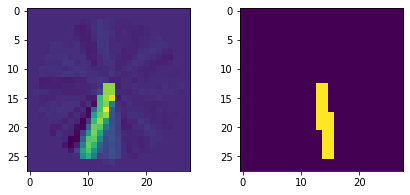

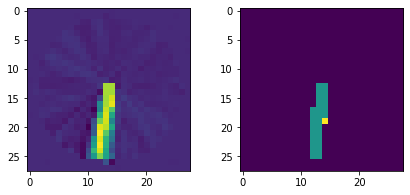

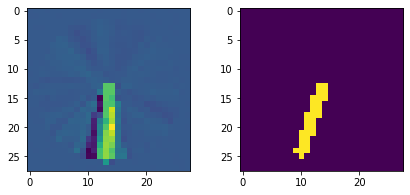

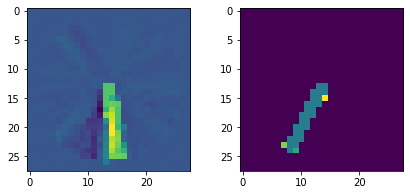

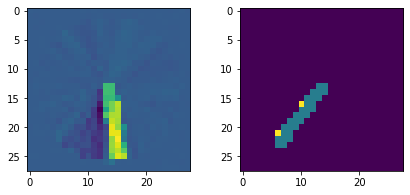

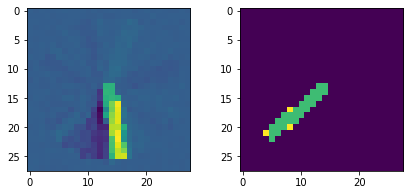

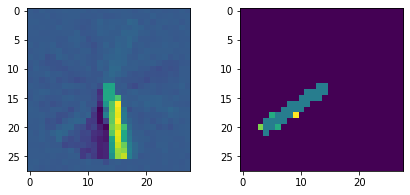

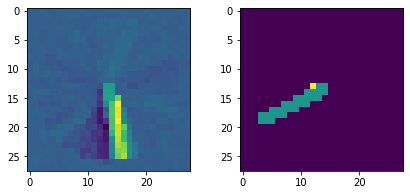

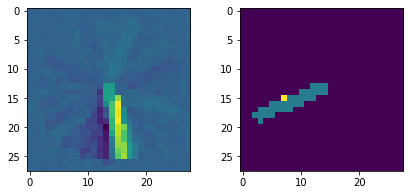

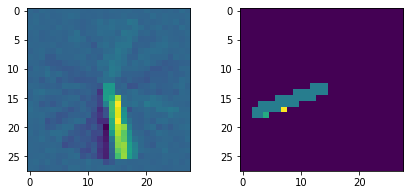

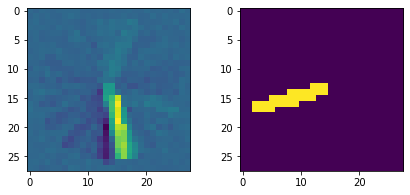

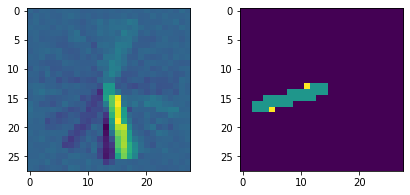

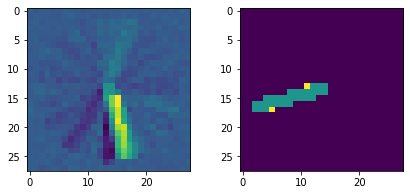

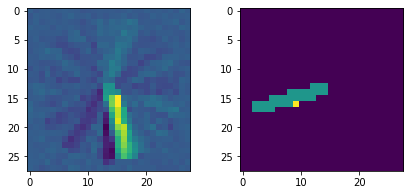

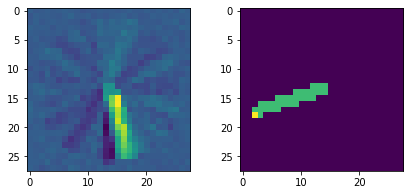

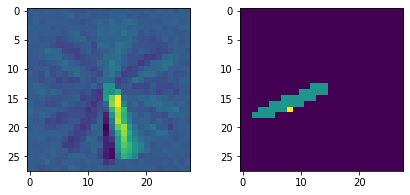

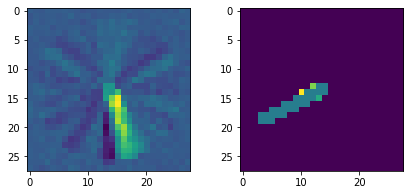

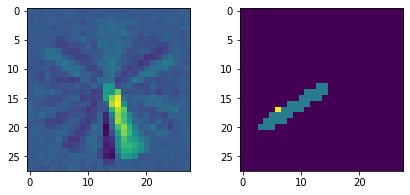

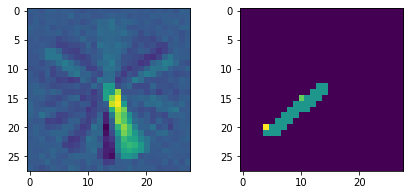

In [34]:
num_iters = 30

for i in range(num_iters):
    fig = plt.figure(figsize=(7, 3))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    ax1.imshow(recon_img[0, i, :, :, 0].detach().numpy())
    ax2.imshow(P_dP[i, :, :, 0].detach().numpy())

In [35]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
# x = torch.linspace(-100, 100, n_grid)
Q, dQ = torch.meshgrid(x, x)  # all (q, p)

# H is Hamiltonian
# (U, V) are the symplectic gradient
L, U, V = torch.zeros(Q.shape), torch.zeros(Q.shape), torch.zeros(Q.shape)

for i in range(n_grid):
    for j in range(n_grid):
        # The current canonical coordinate
        x = torch.cat([Q[i, j].reshape(1, 1), dQ[i, j].reshape(1, 1), torch.zeros(1, 1)], dim=1)
        L[i, j] = test_model.defunc.m.L(x[:, :-1]).detach().cpu()
        grad = test_model.defunc(0, x).detach().cpu()
        U[i, j], V[i, j] = grad[:, 0], grad[:, 1]

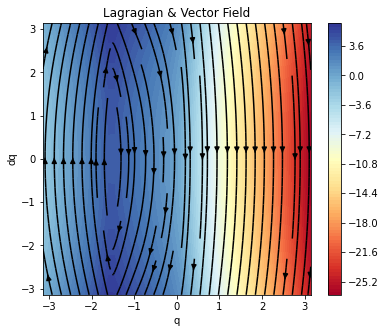

In [36]:
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
CS = ax.contourf(Q, dQ, L, 100, cmap='RdYlBu')
fig.colorbar(CS)

ax.streamplot(Q.T.numpy(), dQ.T.numpy(), U.T.numpy(), V.T.numpy(), color='black')

ax.set_xlim([Q.min(), Q.max()])
ax.set_ylim([dQ.min(), dQ.max()])
ax.set_xlabel("q")
ax.set_ylabel("dq")
ax.set_title("Lagragian & Vector Field")
None

In [37]:
from scipy.integrate import solve_ivp

def dummy(t, y):
    idx = int(torch.tensor(t) / dt)
    dx1 = np.multiply(-y[1], y[2])
    dx2 = np.multiply(y[0], y[2])
    ddq = -10 * y[0] + controls[idx-1] / 2.
    return [dx1, dx2, ddq]

sol = solve_ivp(dummy, [dt, dt*full], obs0, method='Radau', t_eval=t_span.detach().numpy())

In [38]:
est_grad.shape

torch.Size([199, 3])

### Check gradient

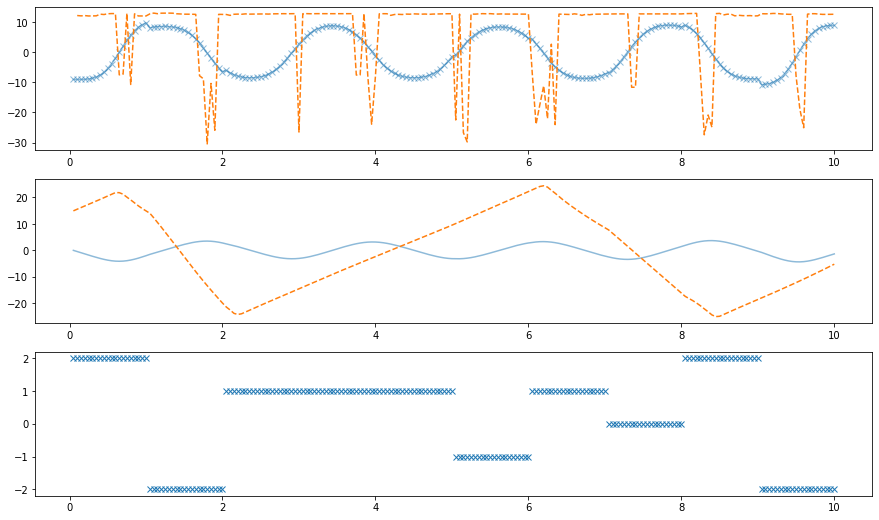

In [39]:
fig = plt.figure(figsize=(15, 9))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

start = 0
end = 500

# Check ddq_est
ax1.plot(t_span.detach().numpy()[start:end], infos[start:end, 2],'x-', alpha=0.5)  # Ground truth
ax1.plot(t_span.detach().numpy()[start+1:end], est_grad[start:end, 1].detach().numpy(), '--')  # LNN

# check dq_est
ax2.plot(t_span.detach().numpy()[start:end], infos[start:end, 1],'-', alpha=0.5)
ax2.plot(t_span.detach().numpy()[start:end], est_z2[:, 1], '--')  # LNN
# ax2.plot(sol.t[start:end], sol.y[2, start:end])

# Plot control for reference
ax3.plot(t_span.detach().numpy()[start:end], controls[start:end],'x')
# None

### Plot Mass Matrix

<ipython-input-40-12ba3b94e7ca>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(x[i])


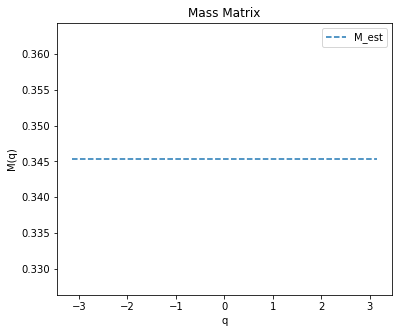

In [40]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

M_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.tensor(x[i])
    M_est[i] = test_model.defunc.m.massMatrixNet(q.view(1, -1)).detach().cpu()[0, 0, 0]

    
M_true = torch.ones(M_est.shape)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), M_est, '--', label='M_est')
# ax.plot(x.detach().numpy(), M_true, label='M_true', alpha=0.5)

ax.legend()
# ax.set_ylim([0, 1.1])
ax.set_xlabel("q")
ax.set_ylabel("M(q)")
ax.set_title("Mass Matrix")
None

### Plot Potential

<ipython-input-41-4d27b8dd309a>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(x[i])


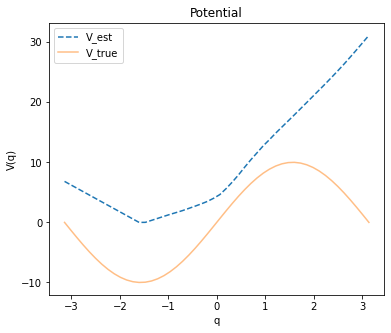

In [41]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)

V_true = 1. * 10 * torch.sin(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.tensor(x[i])
    V_est[i] = test_model.defunc.m.potentialNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='V_est')
ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("V(q)")
ax.set_title("Potential")
None

### Plot Control

<ipython-input-42-9cbb3257d4ab>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  q = torch.tensor(x[i])


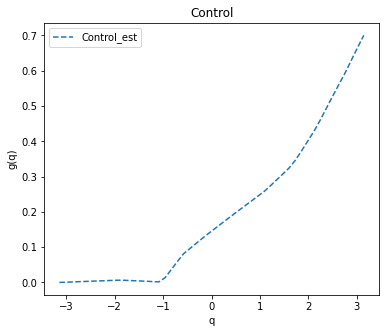

In [42]:
n_grid = 50
x = torch.linspace(-np.pi, np.pi, n_grid)
x1, x2 = torch.meshgrid(x, x)  # (cos q, sin q)

Control = 1. * 10 * torch.ones_like(x)

V_est = torch.zeros(x.shape)

for i in range(n_grid):
    q = torch.tensor(x[i])
    V_est[i] = test_model.defunc.m.controlNet(q.view(1, -1)).detach().cpu()

V_est = V_est - min(V_est)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111)
ax.plot(x.detach().numpy(), V_est, '--', label='Control_est')
# ax.plot(x.detach().numpy(), V_true, label='V_true', alpha=0.5)

ax.legend()
ax.set_xlabel("q")
ax.set_ylabel("g(q)")
ax.set_title("Control")
None

## Conclusion